In [18]:
import spatialdata
import spatialdata_plot
import dask_image.imread
import dask.array as da
import napari_spatialdata
import matplotlib.pyplot as plt
from matplotlib import patches
import geopandas as gpd
import anndata as ad
import numpy as np

import sys, os
sys.path.append(os.path.abspath("../src/opendvp/"))
import anndata_utils

for package in [spatialdata, napari_spatialdata]:
    print(f"{package.__name__}: {package.__version__}")

#paths
path_to_mIF_image = "/Volumes/Extreme SSD/P26_BCCN/P26E07_E08_E09_SOPA_Gates/processed_images/991.ome.tif"
path_to_HE_image = "/Volumes/Extreme SSD/P26_BCCN/P26_HE_staining/240624_SF_P26_mDVP_991_HE.ome.tiff"
path_to_mask = "/Volumes/Extreme SSD/P26_BCCN/P26E07_E08_E09_SOPA_Gates/expanded-masks/991.tif"
path_to_quant = "/Volumes/Extreme SSD/P26_BCCN/P26E07_E08_E09_SOPA_Gates/quantification/991.csv"

spatialdata: 0.3.0
napari_spatialdata: 0.5.5


In [2]:
! mamba list

# packages in environment at /opt/homebrew/Caskroom/mambaforge/base/envs/spatialdata:
#
# Name                    Version                   Build  Channel
aiobotocore               2.5.4                    pypi_0    pypi
aiohappyeyeballs          2.4.6              pyhd8ed1ab_0    conda-forge
aiohttp                   3.11.13         py312h998013c_0    conda-forge
aioitertools              0.12.0                   pypi_0    pypi
aiosignal                 1.3.2              pyhd8ed1ab_0    conda-forge
alabaster                 1.0.0              pyhd8ed1ab_1    conda-forge
anndata                   0.11.3             pyhd8ed1ab_0    conda-forge
annotated-types           0.7.0              pyhd8ed1ab_1    conda-forge
aom                       3.9.1                h7bae524_0    conda-forge
app-model                 0.3.0              pyhd8ed1ab_0    conda-forge
appdirs                   1.4.4              pyhd8ed1ab_1    conda-forge
appnope                   0.1.4              pyhd8ed1ab_

# Create sdata

In [3]:
sdata = spatialdata.SpatialData()

## images and mask

In [4]:
#parse in images

sdata['mIF'] = spatialdata.models.Image2DModel.parse(
    data=dask_image.imread.imread(path_to_mIF_image),
    dims=['c', 'y', 'x'],
    transformations=None,
    scale_factors=[3,3,3],
    )

In [6]:
#parse labels
sdata['mask'] = spatialdata.models.Labels2DModel.parse(
    data=da.squeeze(dask_image.imread.imread(path_to_mask)),
    dims=['y','x'],
    scale_factors=[3,3,3],
    )

In [8]:
sdata['mask_polygons'] = spatialdata.to_polygons(sdata['mask'])

In [11]:
# parse polygons index
sdata['mask_polygons']['label'] = sdata['mask_polygons']['label'].astype('int')
sdata['mask_polygons'].index = sdata['mask_polygons'].index.astype('int')

In [12]:
sdata['mask_polygons']

,label,geometry
label,,
1,1,"POLYGON ((35840.5 29406, 35840 29405.5, 35839...."
2,2,"POLYGON ((36181.5 29440, 36181.5 29439, 36181 ..."
3,3,"POLYGON ((38461 29530.5, 38460 29530.5, 38459...."
4,4,"POLYGON ((35073 29552.5, 35074 29552.5, 35075 ..."
5,5,"POLYGON ((36786.5 29952, 36786.5 29951, 36786 ..."
...,...,...
685801,685801,"POLYGON ((46080.5 40372, 46080 40371.5, 46079 ..."
685802,685802,"POLYGON ((47713 40404.5, 47712 40404.5, 47711...."
685803,685803,"POLYGON ((48446 40398.5, 48445 40398.5, 48444 ..."


## Link polygons with imaging table

In [15]:
adata_imaging = anndata_utils.read_quant("../data/imaging/991.csv")

2025-03-18 09:43:27.825 | INFO     | anndata_utils:read_quant:16 -  ---- read_quant : version number 1.1.0 ----
2025-03-18 09:43:32.096 | INFO     | anndata_utils:read_quant:36 -  685805 cells and 75 variables
2025-03-18 09:43:32.097 | INFO     | anndata_utils:read_quant:37 -  ---- read_quant is done, took 4s  ----


In [ ]:
def ensure_one_based_index(adata, cellid_col="CellID"):
    """
    Ensures the specified CellID column and index are 1-based.
    Converts data to integers if needed.
    
    Parameters:
    - adata: AnnData object
    - cellid_col: str, name of the column with cell IDs (default: "CellID")
    
    Returns:
    - adata: updated AnnData object
    """
    
    # Check if the column exists
    if cellid_col not in adata.obs.columns:
        raise ValueError(f"Column '{cellid_col}' not found in adata.obs.")
    
    # Ensure the CellID column and index are integers
    if not np.issubdtype(adata.obs[cellid_col].dtype, np.integer):
        adata.obs[cellid_col] = adata.obs[cellid_col].astype(int)

    if not np.issubdtype(adata.obs.index.dtype, np.integer):
        adata.obs.index = adata.obs.index.astype(int)
    
    # Check if both are 0-based and increment if needed
    if (adata.obs[cellid_col].min() == 0) and (adata.obs.index.min() == 0):
        adata.obs[cellid_col] += 1
        adata.obs.index += 1
        print(f"✅ Incremented '{cellid_col}' and index to 1-based numbering.")
    else:
        print("⏭️ Skipping increment: CellID or index is not 0-based.")
    
    return adata

ensure_one_based_index(adata_imaging,cellid_col="CellID")

✅ Incremented CellID and index to 1-based numbering.


In [22]:
adata_imaging.obs["shapes"] = "mask_polygons"
adata_imaging.obs["shapes"] = adata_imaging.obs["shapes"].astype("category")
sdata["imaging"] = spatialdata.models.TableModel.parse(adata_imaging, region = "mask_polygons", region_key = "shapes", instance_key = "CellID")

# QuPath contours

In [ ]:
gdf = gpd.read_file("/Users/jnimoca/Jose_BI/4_Projects/P26_BCCN/P26E18_ProteomicAnalysis/data/geojsons/clean_gdf.geojson")
gdf.index = gdf.new_class_name # this column has matching ids with proteomic table
sdata['primary_lmd_contours'] = spatialdata.models.ShapesModel.parse(gdf[gdf.biopsy_type == "Primary"])
sdata['relapse_lmd_contours'] = spatialdata.models.ShapesModel.parse(gdf[gdf.biopsy_type == "Relapse"])

In [60]:
sdata

SpatialData object
├── Images
│     └── 'mIF': DataTree[cyx] (15, 44470, 73167), (15, 14823, 24389), (15, 4941, 8129), (15, 1647, 2709)
├── Labels
│     └── 'mask': DataTree[yx] (44470, 73167), (14823, 24389), (4941, 8129), (1647, 2709)
├── Shapes
│     ├── 'mask_polygons': GeoDataFrame shape: (685805, 2) (2D shapes)
│     ├── 'primary_lmd_contours': GeoDataFrame shape: (234, 18) (2D shapes)
│     └── 'relapse_lmd_contours': GeoDataFrame shape: (214, 18) (2D shapes)
└── Tables
      └── 'imaging': AnnData (685805, 75)
with coordinate systems:
    ▸ 'global', with elements:
        mIF (Images), mask (Labels), mask_polygons (Shapes), primary_lmd_contours (Shapes), relapse_lmd_contours (Shapes)

## Add qupath annotations, the geojsons

In [89]:
adata_proteomic = ad.read_h5ad("/Users/jnimoca/Jose_BI/4_Projects/P26_BCCN/P26E18_ProteomicAnalysis/data/adatas/20250129_2244_adata.h5ad")
adata_proteomic.obs.columns

Index(['Precursors.Identified', 'Proteins.Identified', 'Total.Quantity',
       'MS1.Signal', 'MS2.Signal', 'FWHM.Scans', 'FWHM.RT',
       'Median.Mass.Acc.MS1', 'Median.Mass.Acc.MS1.Corrected',
       'Median.Mass.Acc.MS2', 'Median.Mass.Acc.MS2.Corrected',
       'MS2.Mass.Instability', 'Normalisation.Instability',
       'Median.RT.Prediction.Acc', 'Average.Peptide.Length',
       'Average.Peptide.Charge', 'Average.Missed.Tryptic.Cleavages',
       'filename', 'Machine', 'Date', 'User_id', 'LC', 'Acquisition', 'Exp_id',
       'Plate_384wp_id', '384wp_well_real', 'Vial', 'Vol_injected',
       'LCMS_run_id', '96wp_well', '96wp_id', 'Biopsy_type', 'RCN', 'RCN_long',
       'replicate', 'class_name'],
      dtype='object')

In [88]:
from shapely.wkt import loads
df = gpd.read_file("/Users/jnimoca/Jose_BI/4_Projects/P26_BCCN/P26E18_ProteomicAnalysis/data/shapes/all_shapes.csv")
df["geometry"] = df["geometry"].apply(lambda x: loads(x) if isinstance(x, str) else x)
gdf = gpd.GeoDataFrame(df, geometry="geometry")
gdf.index = gdf.new_class_name.values
sdata['lmd_contours'] = spatialdata.models.ShapesModel.parse(gdf)
sdata

/opt/homebrew/Caskroom/mambaforge/base/envs/spatialdata/lib/python3.12/site-packages/spatialdata/_core/_elements.py:105: UserWarning: Key `lmd_contours` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)


SpatialData object, with associated Zarr store: /Users/jnimoca/Jose_BI/1_Pipelines/openDVP/data/sdata/sdata_3_mIF_mask_maskpoly_imaging_table.zarr
├── Images
│     └── 'mIF': DataTree[cyx] (15, 44470, 73167), (15, 14823, 24389), (15, 4941, 8129), (15, 1647, 2709)
├── Labels
│     └── 'mask': DataTree[yx] (44470, 73167), (14823, 24389), (4941, 8129), (1647, 2709)
├── Shapes
│     ├── 'lmd_contours': GeoDataFrame shape: (448, 18) (2D shapes)
│     └── 'mask_polygons': GeoDataFrame shape: (685805, 2) (2D shapes)
└── Tables
      └── 'imaging': AnnData (685805, 75)
with coordinate systems:
    ▸ 'global', with elements:
        mIF (Images), mask (Labels), lmd_contours (Shapes), mask_polygons (Shapes)
with the following elements not in the Zarr store:
    ▸ lmd_contours (Shapes)

In [113]:
adata_proteomic.obs["shapes"] = "lmd_contours"
adata_proteomic.obs["shapes"] = adata_proteomic.obs["shapes"].astype("category")
adata_proteomic.obs['class_name'] = adata_proteomic.obs["class_name"].astype("str")
sdata["proteins"] = spatialdata.models.TableModel.parse(adata_proteomic, region = "lmd_contours", region_key = "shapes", instance_key = "class_name")

In [95]:
adata_proteomic.obs.class_name.value_counts().sort_values()

class_name
Primary_RCN3_15     1
Primary_RCN1_38     1
Primary_RCN1_37     1
Primary_RCN1_3      1
Primary_RCN1_5      1
                   ..
Relapse_RCN5_19     1
Relapse_RCN5_21     1
Relapse_RCN5_22     1
Relapse_RCN5_10     1
Primary_RCN1_164    2
Name: count, Length: 218, dtype: int64

In [ ]:
# this had to be done because somehow there was a sample duplication, digitally it looks legit.
# Somehow sample L10 from relapse plate, appeared in two evotips.. I will keep one for now
adata_proteomic = adata_proteomic[adata_proteomic.obs.LCMS_run_id != 8551].copy()

In [114]:
sdata

SpatialData object, with associated Zarr store: /Users/jnimoca/Jose_BI/1_Pipelines/openDVP/data/sdata/sdata_3_mIF_mask_maskpoly_imaging_table.zarr
├── Images
│     └── 'mIF': DataTree[cyx] (15, 44470, 73167), (15, 14823, 24389), (15, 4941, 8129), (15, 1647, 2709)
├── Labels
│     └── 'mask': DataTree[yx] (44470, 73167), (14823, 24389), (4941, 8129), (1647, 2709)
├── Shapes
│     ├── 'lmd_contours': GeoDataFrame shape: (448, 18) (2D shapes)
│     └── 'mask_polygons': GeoDataFrame shape: (685805, 2) (2D shapes)
└── Tables
      ├── 'imaging': AnnData (685805, 75)
      └── 'proteins': AnnData (218, 4766)
with coordinate systems:
    ▸ 'global', with elements:
        mIF (Images), mask (Labels), lmd_contours (Shapes), mask_polygons (Shapes)
with the following elements not in the Zarr store:
    ▸ proteins (Tables)
    ▸ lmd_contours (Shapes)

In [115]:
sdata.write("../data/sdata/sdata_4_mIF_mask_imgtable_protable.zarr")

INFO     The SpatialData object is not self-contained (i.e. it contains some elements that are Dask-backed from    
         locations outside ../data/sdata/sdata_4_mIF_mask_imgtable_protable.zarr). Please see the documentation of 
         `is_self_contained()` to understand the implications of working with SpatialData objects that are not     
         self-contained.                                                                                           
INFO     The Zarr backing store has been changed from ../data/sdata/sdata_3_mIF_mask_maskpoly_imaging_table.zarr   
         the new file path: ../data/sdata/sdata_4_mIF_mask_imgtable_protable.zarr                                  


In [116]:
sdata

SpatialData object, with associated Zarr store: /Users/jnimoca/Jose_BI/1_Pipelines/openDVP/data/sdata/sdata_4_mIF_mask_imgtable_protable.zarr
├── Images
│     └── 'mIF': DataTree[cyx] (15, 44470, 73167), (15, 14823, 24389), (15, 4941, 8129), (15, 1647, 2709)
├── Labels
│     └── 'mask': DataTree[yx] (44470, 73167), (14823, 24389), (4941, 8129), (1647, 2709)
├── Shapes
│     ├── 'lmd_contours': GeoDataFrame shape: (448, 18) (2D shapes)
│     └── 'mask_polygons': GeoDataFrame shape: (685805, 2) (2D shapes)
└── Tables
      ├── 'imaging': AnnData (685805, 75)
      └── 'proteins': AnnData (218, 4766)
with coordinate systems:
    ▸ 'global', with elements:
        mIF (Images), mask (Labels), lmd_contours (Shapes), mask_polygons (Shapes)
with the following Dask-backed elements not being self-contained:
    ▸ mIF: /Users/jnimoca/Jose_BI/1_Pipelines/openDVP/data/sdata/sdata_3_mIF_mask_maskpoly_imaging_table.zarr/images/mIF
    ▸ mask: /Users/jnimoca/Jose_BI/1_Pipelines/openDVP/data/sdata/sda

In [3]:
sdata = spatialdata.read_zarr("../data/sdata/sdata_4_mIF_mask_imgtable_protable.zarr")

/opt/homebrew/Caskroom/mambaforge/base/envs/spatialdata/lib/python3.12/site-packages/zarr/creation.py:614: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)


In [118]:
interactive = napari_spatialdata.Interactive(sdata)
interactive.run()

In [4]:
sdata

SpatialData object, with associated Zarr store: /Users/jnimoca/Jose_BI/1_Pipelines/openDVP/data/sdata/sdata_4_mIF_mask_imgtable_protable.zarr
├── Images
│     └── 'mIF': DataTree[cyx] (15, 44470, 73167), (15, 14823, 24389), (15, 4941, 8129), (15, 1647, 2709)
├── Labels
│     └── 'mask': DataTree[yx] (44470, 73167), (14823, 24389), (4941, 8129), (1647, 2709)
├── Shapes
│     ├── 'lmd_contours': GeoDataFrame shape: (448, 18) (2D shapes)
│     └── 'mask_polygons': GeoDataFrame shape: (685805, 2) (2D shapes)
└── Tables
      ├── 'imaging': AnnData (685805, 75)
      └── 'proteins': AnnData (218, 4766)
with coordinate systems:
    ▸ 'global', with elements:
        mIF (Images), mask (Labels), lmd_contours (Shapes), mask_polygons (Shapes)

## Add voronoi shapes

In [5]:
path_to_voronoi_cells = "/Volumes/Extreme SSD/P26_BCCN/P26E10_E11_ImageAnalysis/data/geojsons/Voronois/20241004_1157_991_cells_voronoi.geojson"
path_to_voronoi_RCN = "/Volumes/Extreme SSD/P26_BCCN/P26E10_E11_ImageAnalysis/data/geojsons/Voronois/20241004_1157_991_RCN_voronoi.geojson"

In [6]:
sdata['voronoi_cells'] = spatialdata.models.ShapesModel.parse(gpd.read_file(path_to_voronoi_cells))
sdata['voronoi_RCN'] = spatialdata.models.ShapesModel.parse(gpd.read_file(path_to_voronoi_RCN))

In [7]:
sdata

SpatialData object, with associated Zarr store: /Users/jnimoca/Jose_BI/1_Pipelines/openDVP/data/sdata/sdata_4_mIF_mask_imgtable_protable.zarr
├── Images
│     └── 'mIF': DataTree[cyx] (15, 44470, 73167), (15, 14823, 24389), (15, 4941, 8129), (15, 1647, 2709)
├── Labels
│     └── 'mask': DataTree[yx] (44470, 73167), (14823, 24389), (4941, 8129), (1647, 2709)
├── Shapes
│     ├── 'lmd_contours': GeoDataFrame shape: (448, 18) (2D shapes)
│     ├── 'mask_polygons': GeoDataFrame shape: (685805, 2) (2D shapes)
│     ├── 'voronoi_RCN': GeoDataFrame shape: (18901, 31) (2D shapes)
│     └── 'voronoi_cells': GeoDataFrame shape: (597727, 33) (2D shapes)
└── Tables
      ├── 'imaging': AnnData (685805, 75)
      └── 'proteins': AnnData (218, 4766)
with coordinate systems:
    ▸ 'global', with elements:
        mIF (Images), mask (Labels), lmd_contours (Shapes), mask_polygons (Shapes), voronoi_RCN (Shapes), voronoi_cells (Shapes)
with the following elements not in the Zarr store:
    ▸ voronoi_RCN 

In [13]:
sdata

SpatialData object, with associated Zarr store: /Users/jnimoca/Jose_BI/1_Pipelines/openDVP/data/sdata/sdata_4_mIF_mask_imgtable_protable.zarr
├── Images
│     └── 'mIF': DataTree[cyx] (15, 44470, 73167), (15, 14823, 24389), (15, 4941, 8129), (15, 1647, 2709)
├── Labels
│     └── 'mask': DataTree[yx] (44470, 73167), (14823, 24389), (4941, 8129), (1647, 2709)
├── Shapes
│     ├── 'lmd_contours': GeoDataFrame shape: (448, 18) (2D shapes)
│     ├── 'mask_polygons': GeoDataFrame shape: (685805, 2) (2D shapes)
│     ├── 'voronoi_RCN': GeoDataFrame shape: (18901, 31) (2D shapes)
│     └── 'voronoi_cells': GeoDataFrame shape: (597727, 33) (2D shapes)
└── Tables
      ├── 'imaging': AnnData (685805, 75)
      └── 'proteins': AnnData (218, 4766)
with coordinate systems:
    ▸ 'global', with elements:
        mIF (Images), mask (Labels), lmd_contours (Shapes), mask_polygons (Shapes), voronoi_RCN (Shapes), voronoi_cells (Shapes)
with the following elements not in the Zarr store:
    ▸ voronoi_RCN 

In [26]:
# loading shapes takes very long
# lets subset

bb_xmin = 35000
bb_ymin = 25000
bb_w = 1000
bb_h = 1000
bb_xmax = bb_xmin + bb_w
bb_ymax = bb_ymin + bb_h

cropped_sdata = sdata.query.bounding_box(
    axes=["x", "y"],
    min_coordinate=[bb_xmin, bb_ymin],
    max_coordinate=[bb_xmax, bb_ymax],
    target_coordinate_system="global",
    filter_table=True,
)

In [27]:
cropped_sdata

SpatialData object
├── Images
│     └── 'mIF': DataTree[cyx] (15, 1000, 1000), (15, 333, 333), (15, 111, 111), (15, 37, 37)
├── Labels
│     └── 'mask': DataTree[yx] (1000, 1000), (333, 333), (111, 111), (37, 37)
├── Shapes
│     ├── 'lmd_contours': GeoDataFrame shape: (2, 18) (2D shapes)
│     ├── 'mask_polygons': GeoDataFrame shape: (568, 2) (2D shapes)
│     ├── 'voronoi_RCN': GeoDataFrame shape: (16, 31) (2D shapes)
│     └── 'voronoi_cells': GeoDataFrame shape: (583, 33) (2D shapes)
└── Tables
      ├── 'imaging': AnnData (568, 75)
      └── 'proteins': AnnData (1, 4766)
with coordinate systems:
    ▸ 'global', with elements:
        mIF (Images), mask (Labels), lmd_contours (Shapes), mask_polygons (Shapes), voronoi_RCN (Shapes), voronoi_cells (Shapes)

In [19]:
interactive = napari_spatialdata.Interactive(cropped_sdata)
interactive.run()

In [20]:
sdata.write_element(['voronoi_RCN', 'voronoi_cells'])

INFO     Value for parameter 'color' appears to be a color, using it as such.                                      


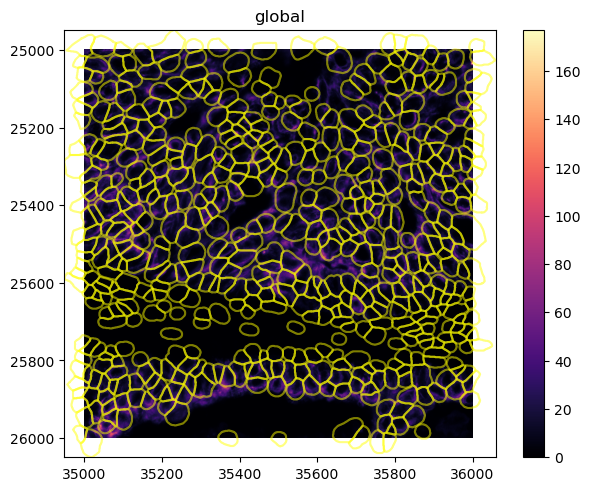

In [43]:
(cropped_sdata.pl.render_images(
        element="mIF", 
        channel=7, 
        cmap="magma"
    )
    .pl.render_shapes(
        element='mask_polygons',
        color='yellow',
        outline_color="yellow",
        fill_alpha=0.0,
        outline_alpha=0.5,
        contour_px=2
    )
    # .pl.render_points(
    #     element
    # )

.pl.show()
)

In [44]:
cropped_sdata['imaging'].obs

,CellID,Y_centroid,X_centroid,Area,MajorAxisLength,MinorAxisLength,Eccentricity,Orientation,Extent,Solidity,shapes
573264,573264,24991.269240,35214.342174,4223.0,101.583078,56.343463,0.832081,-0.955753,284.291414,0.882734,mask_polygons
573287,573287,24979.587744,35811.644383,1077.0,44.480900,33.199563,0.665522,-0.042447,137.941125,0.927649,mask_polygons
573295,573295,24984.076445,35782.362337,1609.0,56.462435,36.854231,0.757598,-0.052893,156.468037,0.967529,mask_polygons
573297,573297,24989.097754,34996.272127,2271.0,67.945636,48.520306,0.700039,-1.030736,215.622366,0.887109,mask_polygons
573298,573298,24985.862992,35854.323622,2540.0,60.012424,54.484996,0.419197,1.524121,192.509668,0.967988,mask_polygons
...,...,...,...,...,...,...,...,...,...,...,...
576609,576609,26012.649871,35017.576315,2719.0,71.408566,49.404733,0.722032,-0.193401,207.823376,0.938881,mask_polygons
576615,576615,26009.105861,35754.440789,1672.0,60.907265,35.754516,0.809564,0.079908,161.639610,0.958716,mask_polygons
576618,576618,25999.186170,35370.049867,1504.0,50.627669,38.115169,0.658189,1.291224,146.124892,0.978530,mask_polygons
576627,576627,26007.805441,35783.436933,1213.0,50.334776,32.203136,0.768559,-0.193508,139.497475,0.966534,mask_polygons


In [46]:
cropped_sdata

SpatialData object
├── Images
│     └── 'mIF': DataTree[cyx] (15, 1000, 1000), (15, 333, 333), (15, 111, 111), (15, 37, 37)
├── Labels
│     └── 'mask': DataTree[yx] (1000, 1000), (333, 333), (111, 111), (37, 37)
├── Shapes
│     ├── 'lmd_contours': GeoDataFrame shape: (2, 18) (2D shapes)
│     ├── 'mask_polygons': GeoDataFrame shape: (568, 2) (2D shapes)
│     ├── 'voronoi_RCN': GeoDataFrame shape: (16, 31) (2D shapes)
│     └── 'voronoi_cells': GeoDataFrame shape: (583, 33) (2D shapes)
└── Tables
      ├── 'imaging': AnnData (568, 75)
      └── 'proteins': AnnData (1, 4766)
with coordinate systems:
    ▸ 'global', with elements:
        mIF (Images), mask (Labels), lmd_contours (Shapes), mask_polygons (Shapes), voronoi_RCN (Shapes), voronoi_cells (Shapes)

## Fix shapes

### Read geojson, split into primary and relapse

In [42]:
gdf = gpd.read_file("/Users/jnimoca/Jose_BI/4_Projects/P26_BCCN/P26E18_ProteomicAnalysis/data/geojsons/clean_gdf.geojson")
gdf.head()

,id,objectType,classification,biopsy_type,RCN,Replicate,new_class_name,geometry
0,a5467a11-8ace-459b-aa56-0441e9758097,annotation,"{ ""name"": ""Primary_refill_92"", ""color"": [ 88, ...",Primary,RCN1,192,Primary_RCN1_192,"POLYGON ((60793.2 33094.17, 60780.64 33094.56,..."
1,fce4daaa-1708-4e71-941c-6bffa711c953,annotation,"{ ""name"": ""Primary_refill_64"", ""color"": [ 84, ...",Primary,RCN1,164,Primary_RCN1_164,"POLYGON ((66268.2 29298.17, 66255.64 29298.56,..."
2,37dc29b0-6c88-4a33-a439-40876c8b703a,annotation,"{ ""name"": ""Primary_refill_63"", ""color"": [ 84, ...",Primary,RCN1,163,Primary_RCN1_163,"POLYGON ((57175.2 21723.17, 57162.64 21723.56,..."
3,2e7dfb20-c513-4ade-abab-5e17827de13a,annotation,"{ ""name"": ""Primary_refill_62"", ""color"": [ 84, ...",Primary,RCN1,162,Primary_RCN1_162,"POLYGON ((58135.2 22802.17, 58122.64 22802.56,..."
4,f4ac92ee-cfa3-49ea-957c-c846cd887df8,annotation,"{ ""name"": ""Primary_refill_60"", ""color"": [ 85, ...",Primary,RCN1,160,Primary_RCN1_160,"POLYGON ((61068.2 29254.17, 61055.64 29254.56,..."


In [ ]:
gdf = gpd.read_file("/Volumes/Extreme SSD/P26_BCCN/P26E17_LCMS_991_992_280samples/geojsons/spatialdata/20241218_all_shapes_448shapes_301samples.geojson")


In [4]:
adata_proteomic = ad.read_h5ad("/Users/jnimoca/Jose_BI/4_Projects/P26_BCCN/P26E18_ProteomicAnalysis/data/adatas/20250129_2244_adata.h5ad")

In [ ]:
shape_map = {"Primary" : "primary_lmd_contours", "Relapse": "relapse_lmd_contours"}
adata_proteomic.obs["shapes"] = adata_proteomic.obs['Biopsy_type'].map(shape_map)
adata_proteomic.obs["shapes"] = adata_proteomic.obs["shapes"].astype("category")
adata_proteomic.obs['class_name'] = adata_proteomic.obs["class_name"].astype("str")
adata_proteomic = adata_proteomic[adata_proteomic.obs.LCMS_run_id != 8551].copy() #by previous inspection

In [17]:
sdata["proteins"] = spatialdata.models.TableModel.parse(
    adata_proteomic, 
    region = ["primary_lmd_contours", "relapse_lmd_contours"],
    region_key = "shapes", 
    instance_key = "class_name"
    )

In [ ]:
bb_xmin = 35000
bb_ymin = 25000
bb_w = 4000
bb_h = 4000
bb_xmax = bb_xmin + bb_w
bb_ymax = bb_ymin + bb_h

cropped_sdata = sdata.query.bounding_box(
    axes=["x", "y"],
    min_coordinate=[bb_xmin, bb_ymin],
    max_coordinate=[bb_xmax, bb_ymax],
    target_coordinate_system="global",
    filter_table=True,
)

In [6]:
interactive = napari_spatialdata.Interactive(cropped_sdata)
interactive.run()

In [ ]:
interactive = napari_spatialdata.Interactive(sdata)
interactive.run()

: 

## Parse in proper imaging table with phenotypes and RCNs

In [67]:
adata_imaging = ad.read_h5ad("/Volumes/Extreme SSD/P26_BCCN/P26E10_E11_ImageAnalysis/data/adatas/20241002_1218_991_phenotyped.h5ad")

In [68]:
adata_imaging

AnnData object with n_obs × n_vars = 610182 × 8
    obs: 'CellID', 'Y_centroid', 'X_centroid', 'Area', 'MajorAxisLength', 'MinorAxisLength', 'Eccentricity', 'Orientation', 'Extent', 'Solidity', 'filter_by_ann', 'mean_DAPI_bg_abs_above_value', 'mean_DAPI_bg_abs_below_value', 'Area_filter_nottoobig', 'Area_filter_nottoolow', 'Area_filter', 'DAPI_ratio', 'DAPI_ratio_pass_nottoolow', 'DAPI_ratio_pass_nottoohigh', 'DAPI_ratio_pass', 'imageid', 'phenotype'
    var: 'math', 'marker'
    uns: 'gates'

In [70]:
adata_imaging.obs.columns

Index(['CellID', 'Y_centroid', 'X_centroid', 'Area', 'MajorAxisLength',
       'MinorAxisLength', 'Eccentricity', 'Orientation', 'Extent', 'Solidity',
       'filter_by_ann', 'mean_DAPI_bg_abs_above_value',
       'mean_DAPI_bg_abs_below_value', 'Area_filter_nottoobig',
       'Area_filter_nottoolow', 'Area_filter', 'DAPI_ratio',
       'DAPI_ratio_pass_nottoolow', 'DAPI_ratio_pass_nottoohigh',
       'DAPI_ratio_pass', 'imageid', 'phenotype'],
      dtype='object')

In [73]:
adata_imaging.obs.phenotype.value_counts()

phenotype
Unknown           218068
Cancer_cells      216397
CD4_Tcells        109335
COL1A1_cells       45124
CD8_Tcells          8826
Vimentin_cells      7933
B_cells             3578
Macrophages          921
Name: count, dtype: int64

In [7]:
adata = ad.read_h5ad("/Volumes/Extreme SSD/P26_BCCN/P26E10_E11_ImageAnalysis/data/adatas/20241004_1107_991_992_knn_RCN.h5ad")

In [8]:
adata

AnnData object with n_obs × n_vars = 1615233 × 8
    obs: 'CellID', 'Y_centroid', 'X_centroid', 'Area', 'MajorAxisLength', 'MinorAxisLength', 'Eccentricity', 'Orientation', 'Extent', 'Solidity', 'filter_by_ann', 'mean_DAPI_bg_abs_above_value', 'mean_DAPI_bg_abs_below_value', 'Area_filter_nottoobig', 'Area_filter_nottoolow', 'Area_filter', 'DAPI_ratio', 'DAPI_ratio_pass_nottoolow', 'DAPI_ratio_pass_nottoohigh', 'DAPI_ratio_pass', 'imageid', 'phenotype', 'spatial_lda_knn7_kmeans_k7', 'spatial_lda_knn14_kmeans_k7', 'spatial_lda_knn21_kmeans_k7', 'spatial_lda_knn30_kmeans_k7', 'spatial_lda_knn40_kmeans_k7', 'spatial_lda_knn50_kmeans_k7'
    var: 'math', 'marker'
    uns: 'spatial_lda_knn14', 'spatial_lda_knn14_probability', 'spatial_lda_knn21', 'spatial_lda_knn21_probability', 'spatial_lda_knn30', 'spatial_lda_knn30_probability', 'spatial_lda_knn40', 'spatial_lda_knn40_probability', 'spatial_lda_knn50', 'spatial_lda_knn50_probability', 'spatial_lda_knn7', 'spatial_lda_knn7_probability'

In [ ]:
# add linker column to adata.obs with CellID...

In [13]:
adata.obs

,CellID,Y_centroid,X_centroid,Area,MajorAxisLength,MinorAxisLength,Eccentricity,Orientation,Extent,Solidity,...,DAPI_ratio_pass_nottoohigh,DAPI_ratio_pass,imageid,phenotype,spatial_lda_knn7_kmeans_k7,spatial_lda_knn14_kmeans_k7,spatial_lda_knn21_kmeans_k7,spatial_lda_knn30_kmeans_k7,spatial_lda_knn40_kmeans_k7,spatial_lda_knn50_kmeans_k7
0,0.0,29410.806452,35874.857801,1519.0,98.696620,30.646839,0.950568,-1.524977,228.651804,0.676615,...,True,True,991,Cancer_cells,1,6,4,5,2,0
1,1.0,29445.080408,36162.243140,1567.0,50.422862,39.687556,0.616832,0.160002,148.710678,0.975109,...,True,True,991,Cancer_cells,4,6,4,5,2,0
2,2.0,29505.171707,38455.235122,1025.0,40.280587,34.195207,0.528513,-0.346644,131.438600,0.927602,...,True,True,991,Cancer_cells,1,1,1,1,2,0
3,3.0,29539.721673,35060.844867,1315.0,61.049935,28.208869,0.886848,-1.447088,151.254834,0.947406,...,True,True,991,CD4_Tcells,3,0,6,6,1,6
4,4.0,29982.642779,36765.660558,3656.0,84.178897,57.384893,0.731630,0.251203,243.379726,0.926743,...,True,True,991,Cancer_cells,1,1,1,1,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1615228,1134342.0,27270.642157,37569.550980,1020.0,39.707795,32.947621,0.558132,-0.657307,121.639610,0.955951,...,True,True,992,Unknown,2,2,0,0,6,3
1615229,1134343.0,27274.343598,38996.906807,1234.0,42.622618,37.495770,0.475501,0.465532,133.781746,0.964063,...,True,True,992,Cancer_cells,1,1,0,0,6,3
1615230,1134344.0,27271.604926,37413.383251,1015.0,60.243974,22.812825,0.925530,-0.625325,144.509668,0.866041,...,True,True,992,Cancer_cells,3,2,0,0,4,3
1615231,1134345.0,27272.320411,38221.301424,1264.0,50.722945,32.740800,0.763775,-1.218716,143.681241,0.953243,...,True,True,992,Cancer_cells,4,1,1,1,4,1


In [12]:
adata.obs.CellID.value_counts(ascending=False)

CellID
592526.0     2
443972.0     2
443966.0     2
443967.0     2
443968.0     2
            ..
740469.0     1
740468.0     1
740467.0     1
740466.0     1
1134346.0    1
Name: count, Length: 1062489, dtype: int64

In [15]:
sdata['proteins']

AnnData object with n_obs × n_vars = 218 × 4766
    obs: 'Precursors.Identified', 'Proteins.Identified', 'Total.Quantity', 'MS1.Signal', 'MS2.Signal', 'FWHM.Scans', 'FWHM.RT', 'Median.Mass.Acc.MS1', 'Median.Mass.Acc.MS1.Corrected', 'Median.Mass.Acc.MS2', 'Median.Mass.Acc.MS2.Corrected', 'MS2.Mass.Instability', 'Normalisation.Instability', 'Median.RT.Prediction.Acc', 'Average.Peptide.Length', 'Average.Peptide.Charge', 'Average.Missed.Tryptic.Cleavages', 'filename', 'Machine', 'Date', 'User_id', 'LC', 'Acquisition', 'Exp_id', 'Plate_384wp_id', '384wp_well_real', 'Vial', 'Vol_injected', 'LCMS_run_id', '96wp_well', '96wp_id', 'Biopsy_type', 'RCN', 'RCN_long', 'replicate', 'class_name', 'shapes'
    var: 'Protein.Group', 'Protein.Names', 'First.Protein.Description', 'Genes_simplified'
    uns: 'Biopsy_type_colors', 'RCN_long_colors', 'pca', 'spatialdata_attrs'
    obsm: 'X_pca'
    varm: 'PCs'